In [1]:
import Pkg; Pkg.add(["Plots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false, fmt=:png);
using Printf;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

# Finding Structure with Randomness

**Probabilistic Algorithms for Constructing Approximate Matrix Decompositions**

_Halko, Martinsson, & Tropp, 2011_

## Main points of this article

Matrix factorizations are useful tools for understanding data relationships, but:

- Many are large enough that $O(m^3)$ or $O(mn^2)$ costs are infeasible

- Contrary to precise matrices coming from math and scientific applications, data matrices have errors, omissions, ...

- Data movement is the dominant cost of many algorithms

These points suggest that **random algorithms for approximate matrix factorizations** win out over classic deterministic algorithms in time

... and sometime also in robustness

## Review: low-rank approximation in the SVD

Let

$$\large A = \hat{U} \Sigma V^*$$

be a reduced SVD of $A$. ($\Sigma$ is square.)

### Operator 2-norm matrix approximation

$$\large \mathop{\arg\min}_{\mathrm{rank}(B) \leq r} \| A - B \|_2 = \sum_{k=1}^r u_r \sigma_r v_r^* = \hat U_{1:r} \Sigma_{1:r} (V_{1:r})^*$$

$$\min_{\mathrm{rank}(B) \leq r} \| A - B \|_2 = \sigma_{r+1}$$

### Frobenius norm matrix approximation

$$\large \mathop{\arg\min}_{\mathrm{rank}(B) \leq r} \| A - B \|_F = \sum_{k=1}^r u_r \sigma_r v_r^* = \hat U_{1:r} \Sigma_{1:r} (V_{1:r})^*$$

$$\min_{\mathrm{rank}(B) \leq r} \| A - B \|_2 = \sqrt{\sum_{k=r+1}^n \sigma_{k}^2}$$

If $r \ll n$, the approximation $\sum_{k=1}^r u_r \sigma_r v_r^* = \hat U_{1:r} \Sigma_{1:r} (V_{1:r})^*$ is much smaller than $A$:

- Less storage / work to apply: $O(mr + nr)$ vs $O(mn)$

If we had an oracle that could give us $\hat U_{1:r} \Sigma_{1:r} (V_{1:r})^*$, we would use it any time we need a low-rank approximation.

Without an oracle, how should we compute it?

If we compute the entire reduced SVD and then extract the first $r$ vectors, that defeats the purpose ($O(mn^2)$ work to get our approximation), and may not be feasible.

Are there algorithms available to use that compute just the portion of the SVD that we want?

### Recall how we compute the SVD of $A$ in practice

1. Eigenvalue decomposition of $A^* A$

Discouraged in T&B as unstable:

$$|\tilde \sigma_k - \sigma_k| = O(\epsilon_{\text{machine}}\|A\|^2 / \sigma_k)$$

2. Eigenvalue decomposition of $\begin{bmatrix} 0 & A^* \\ A & 0\end{bmatrix}$

Stable:

$$|\tilde \sigma_k - \sigma_k | = O(\epsilon_{\text{machine}} \|A\|)$$

**Review Q:** Is algorithm 1 unstable for all singular values?

Because the instability is for the smallest values of $\Sigma$ -- the first ones to be dropped in a low-rank approximation -- we see why maybe method 1 is not a bad idea for our purposes.

### Could we use a method that uses the Phase 1 reduction to Hessenberg / bidiagonal form?

This is the most expensive part of the classical QR algorithm $O(mn^2)$, it is too expensive in this case

The QR algorithm without Phase 1 is too expensive as well: then every step requires an $O(mn^2)$ factorization.

What methods did we discuss that converged only a few eigenvalues?

1. Power iteration
2. Inverse iteration (**requires matrix inverse**)
3. Rayleigh Quotient iteration (**requires matrix inverse**)

(We seem to be whittling away all but the most primitive algorithm as too expensive!)

### Recall our algorithm from the constructive uniqueness proof of the SVD

1. Find unit vector $v_1$ that maximizes $\|Av\|_2$ (by the power iteration from a **random initial guess**)

2. $\sigma_1 = \|A v\|_2$, $u_1 = A v / \sigma_1$

3. Project $u_1$ and $v_1$ out of $A$ and recursively find the SVD of the remainder

Our implementation of this was slower than built in methods for computing the full SVD:

1. We converged each $\sigma_k$ completely before proceeding to the next value

2. We didn't project out $u_1$ and $v_1$ as efficiently as we could have

3. By proceeding one vector at a time, our power method used primarily matrix-vector products (_level 2 BLAS_, when high performance usually only comes with matrix-matrix operations, _level 3 BLAS_)

Could we take this basic idea, correct these defficiencies,  and make it faster for computing the leading portion of the SVD?

## Range approximation

Assuming $m \geq n$, a first step that is useful not just for approximate SVD calculations, but other matrix factorizations, is **finding an approxiate orthonormal basis for the range of $A$**,

$$\large A  \approx Q Q^* A.$$

### Making this notion quantitative

We want to find orthonormal $Q$ such that

$$\large \|A - QQ^* A\|_{2} \leq \epsilon.$$ 

Note we are not looking for the optimal $Q$ of some rank that minimizes $\|A - QQ^* A\|_2$.

(**Claim.** The optimality result we stated at the start says that the optimal $Q$ is $U_{1:r}$.)

The range approximation problem statement recognizes that there is some threshold $\epsilon$ at which $Q$ is good enough, determined by:

1. The accuracy of the entries in $A$ (if there is noise that is $O(\epsilon)$ in the entries of $A$, why try to be more accurate than that in your numerical linear algebra?)

2. The accuracy required by a task.

   - Approximate matrix factorizations appear often in recommender systems.  What is the regret if a suboptimal $Q$ is used?

### Using the range approximation $Q$ in an approximate SVD

1. Compute $B = Q^*A$. (Claim: $A \approx Q B$)

2. Compute an SVD of the small matrix $B = \tilde U \Sigma V^*$.

3. Set $U = Q \tilde U$


### Computing the random range approximation $Q$

First suppose we want to find the best approximation with rank at least $k$.

Suppose we first compute $k$ vectors in the range of $A$ randomly,

$$y^{(i)} = A \omega^{(i)}, \quad i = 1, 2, \dots, k.$$

If $A$ has exactly rank $k$, then with probability 1 the $y^{(i)}$ vectors span the range of $A$.  We can compute a QR factorization of the matrix $Y = [y^{(1)} | \cdots | y^{(k)}]$ and be done.

Now suppose $A$ has rank greater than $k$, so that

$$\large A  = \underbrace{B}_{\text{optimal part}} + \underbrace{E}_{\text{remainder}}$$

What we want is a basis of $\mathrm{range}(B)$.

If we only computed $k$ products,

$$y^{(i)} = A \omega^{(i)} = B \omega^{(i)} + E \omega^{(i)}, \quad i = 1, 2, \dots, k,$$


The span of the $y^{(i)}$s will be at an angle to $\mathrm{range}(B)$ because of the $E \omega^{(i)}$ portions (which are orthogonal).

But we are willing to use more than $k$ vectors if necessary.

If we compute

$$y^{(i)} = A \omega^{(i)} = B \omega^{(i)} + E \omega^{(i)}, \quad i = 1, 2, \dots, k + p,$$

Then the span of the $y^{(i)}$s comes closer to containing $\mathrm{range}(B)$ the larger the _safety factor_ $p$ is.

### Proto-algorithm

Given a target rank $k$ and an over sampling parameter $p$,

1. Draw a random $n \times (k+p)$ test matrix $\Omega$.

2. Form the matrix product $Y = A \Omega.$

3. Construct a matrix $Q$ whose columns frm an orthonormal basis of the range of $Y$.

How big does the safety factor $p$ have to be for

$$\large P(\|U_{1:k} - Q Q^* U_{1:k}\|_2 < \epsilon) \approx 1?$$


### HMT Theorem 1.1

If $\Omega \in \mathbb{C}^{m \times (k + p)}$ is a standard normal test matrix and $Q$ is an orthonormal basis of
$Y = A \Omega$, then

$$\large \mathbb{E}\left[\|A - QQ^* A\|\right] \leq \left[1 + \underbrace{\frac{4\sqrt{k+p}}{p-1} \sqrt{\min\{m,n\}}}_{\text{suboptimality}} \right] \sigma_{k+1}$$

### Corollary

$$\large P\left(\|A - QQ^* A\| \leq [1 + 9\sqrt{k+p}\sqrt{\min\{m,n\}} ] \sigma_{k+1}\right) \geq 1 - 3 p^{-p}$$

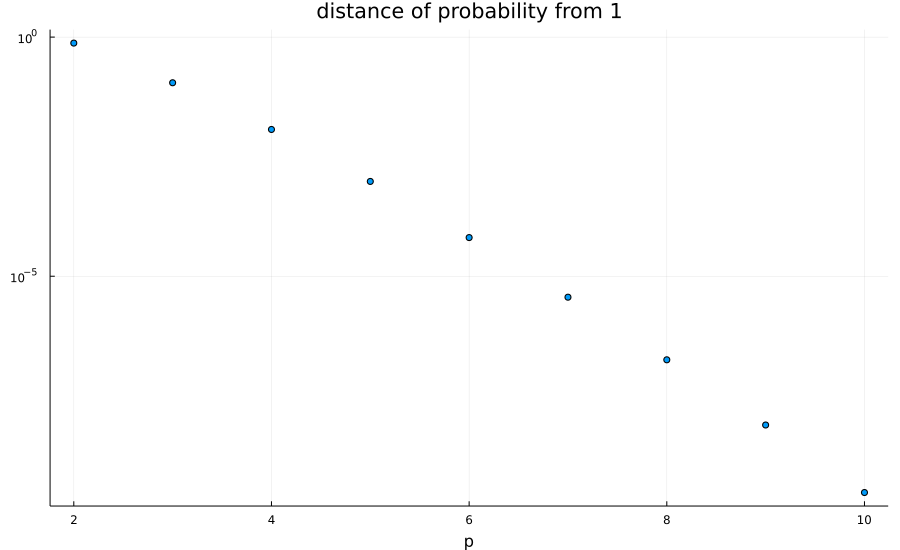

In [9]:
err = [3*p^(-Float64(p)) for p in 2:10]

plot(2:10, err, yscale=:log10, xlabel="p", st=:scatter, title="distance of probability from 1")

This is the type of bound we can get with _one pass_ over $A$ (one matrix-matrix product of size $O(mn(k+p))$).

If we are willing to make multiple passes, a _power iteration_, we can improve on these bounds.

### Power iteration proto-algorithm

Given a target rank $k$ and an over sampling parameter $p$,

1. Draw a random $n \times (k+p)$ test matrix $\Omega$.

2. Form the matrix product $Y = (A^*A)^q A \Omega.$

3. Construct a matrix $Q$ whose columns form an orthonormal basis of the range of $Y$.

### HMT Theorem 1.2

If we choose $p = k$,

$$\large \mathbb{E}\left[\|A - QQ^* A\|\right] \leq \left[1 + 4\sqrt{\frac{2 \min\{m,n\}}{k-1}} \right]^{1/(2q+1)} \sigma_{k+1}$$

## Work complexity analysis

### Work complexity analysis case I: $\Omega$ a standard normal random matrix

### Work complexity analysis case II: $\Omega$ a subsampled random FFT matrix (SRFT)

## Breaking down the proof of theorem 1.1

### Part 1: The deterministic projection part

### Part 2: The random matrix part